In [14]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
from scipy.signal import savgol_filter
import random

In [15]:
data_path = "../data/experiment1-3d"

In [50]:
measures = pd.read_csv(os.path.join(data_path, "measures.csv"), index_col=["subj_id", "session", "route", "intersection_no"])
processed_data = pd.read_csv(os.path.join(data_path, "processed_data.csv"), index_col=["subj_id", "session", "route", "intersection_no"])

In [58]:
len(measures.index.get_level_values("subj_id").unique())

14

In [64]:
len(measures[~measures.is_go_decision].loc[774])

186

In [48]:
def plot_traj(traj, traj_id):
    # idx_bot_spawn = int(traj.iloc[0].idx_bot_spawn)
    # idx_response = int(traj.iloc[0].idx_response)
    # idx_min_distance = int(traj.iloc[0].idx_min_distance)
    idx_bot_spawn = 0
    idx_truck_moving = traj.truck_v.to_numpy().nonzero()[0][0]
    idx_bot_moving = traj.bot_v.to_numpy().nonzero()[0][0]
    # idx_bot_visible = traj.truck_.to_numpy().nonzero()[0][0]
    tta = int(traj.iloc[0].tta_condition)
    d = int(traj.iloc[0].d_condition)

    fig, axes = plt.subplots(5, 1, figsize=(12,9), sharex=True)
    axes[0].plot(traj.t[idx_truck_moving:], traj.ego_v[idx_truck_moving:], color="C0")
    axes[0].plot(traj.t[idx_truck_moving], traj.ego_v[idx_truck_moving], color="C7", ls="", marker="o")
    axes[0].plot(traj.t[idx_bot_moving], traj.ego_v[idx_bot_moving], color="C7", ls="", marker="x")
    axes[0].set_ylabel("ego v")

    axes[1].plot(traj.t[idx_truck_moving:], traj.throttle[idx_truck_moving:], color="C1")
    axes[1].plot(traj.t[idx_truck_moving], traj.throttle[idx_truck_moving], color="C7", ls="", marker="o")
    axes[1].plot(traj.t[idx_bot_moving], traj.throttle[idx_bot_moving], color="C7", ls="", marker="x")
    axes[1].set_ylabel("ego throttle")

    axes[2].plot(traj.t[idx_truck_moving:], traj.d_ego_bot[idx_truck_moving:], color="C2")
    axes[2].plot(traj.t[idx_truck_moving], traj.d_ego_bot[idx_truck_moving], color="C7", ls="", marker="o")
    axes[2].plot(traj.t[idx_bot_moving], traj.d_ego_bot[idx_bot_moving], color="C7", ls="", marker="x")
    axes[2].set_ylabel("d(ego to bot)")

    axes[3].plot(traj.t[idx_truck_moving:], traj.tta[idx_truck_moving:], color="C3")
    axes[3].plot(traj.t[idx_truck_moving], traj.tta[idx_truck_moving], color="C7", ls="", marker="o",
                 label="Truck starts moving")
    axes[3].plot(traj.t[idx_bot_moving], traj.tta[idx_bot_moving], color="C7", ls="", marker="x",
                 label="Bot becomes visible")
    axes[3].set_ylabel("tta")
    # axes[3].set_ylim((0, 7))

    axes[4].plot(traj.t[idx_truck_moving:], traj.bot_v[idx_truck_moving:], color="C6")
    axes[4].plot(traj.t[idx_bot_moving], traj.bot_v[idx_bot_moving], ls="", marker="x", color="C7")
    axes[4].set_ylabel("bot v")
    #
    # axes[5].plot(traj.t[idx_truck_moving:], traj.truck_angle[idx_truck_moving:], color="C4", label="Ego-truck angle")
    # axes[5].plot(traj.t[idx_truck_moving:], traj.bot_angle[idx_truck_moving:], color="C5", label="Ego-bot angle")
    # axes[5].legend()
    # axes[5].set_ylim((-0.1, 0.1))

    axes[-1].set_xlabel("time $t$")

    legend = fig.legend(loc="upper left", bbox_to_anchor=(1.0, 0.9), title=str(traj_id))
    legend.get_title().set_fontsize("18")
    plt.tight_layout()

    return fig, axes

Some participants apparently defaulted to "open-loop" behavior - stop behind the truck, then take the turn without considering the oncoming car. This means they didn't really make gap acceptance decisions so we'll probably need to exclude those

(746, 2, 10, 19)


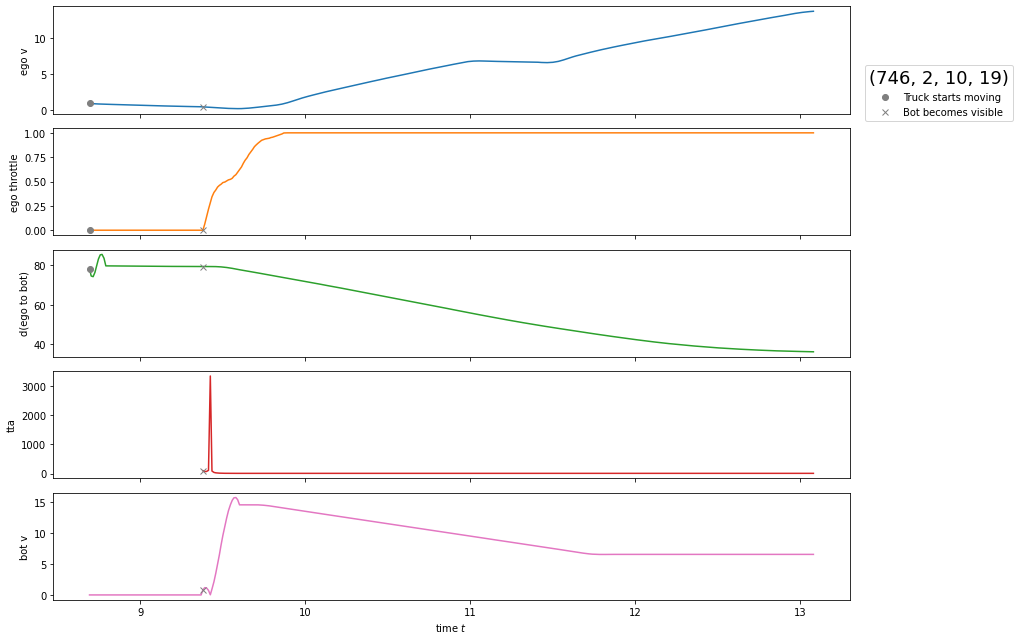

In [54]:
# normal trajectory
# traj_id = (200, 1, 1, 4)

traj_id = random.choice(measures[(measures.RT>0.0) & (measures.RT<0.1) & (measures.is_go_decision)].index)
print(traj_id)
traj = processed_data.loc[traj_id].reset_index()
plot_traj(traj, traj_id);

In [18]:
def get_early_response_rate(subj_measures):
    return len(subj_measures[(measures.RT==0) & (measures.is_go_decision)]) / len(subj_measures[subj_measures.is_go_decision])

measures.groupby("subj_id").apply(get_early_response_rate)

C:\Users\azgonnikov\AppData\Local\Temp\ipykernel_5996\2560366094.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  return len(subj_measures[(measures.RT==0) & (measures.is_go_decision)]) / len(subj_measures[subj_measures.is_go_decision])


subj_id
200    0.0
295    0.0
390    0.0
425    0.0
450    0.0
542    0.0
543    0.0
576    0.0
642    0.0
697    0.0
746    0.0
752    0.0
774    0.0
946    0.0
dtype: float64

In [19]:
measures.groupby("subj_id").apply(lambda m: len(m[m.is_go_decision]) / len(m))

subj_id
200    0.805
295    0.065
390    0.235
425    0.545
450    0.300
542    0.945
543    0.890
576    0.235
642    0.570
697    0.740
746    0.880
752    0.115
774    0.070
946    0.755
dtype: float64

D:\source\cognitive-av\venv\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
D:\source\cognitive-av\venv\lib\site-packages\seaborn\_core.py:1326: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))


Text(0, 0.5, 'Probability of go')

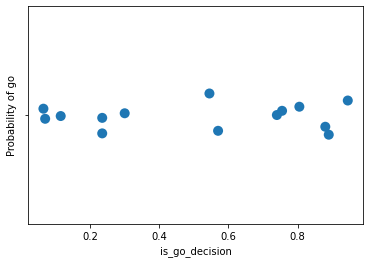

In [21]:
ax = sns.stripplot(measures.groupby("subj_id").is_go_decision.mean(), orient="v", size=10)
ax.set_ylabel("Probability of go")

In [20]:
len(measures[measures.is_negative_rating])/len(measures)

0.05592592592592593

In [31]:
measures["RT"] = measures["RT_gas"]

In [37]:
# measures.loc[~measures.is_go_decision, ["RT"]] = measures.loc[~measures.is_go_decision, ["RT_yield"]]
measures.loc[~measures.is_go_decision, ["RT"]] = measures.loc[~measures.is_go_decision, ["RT_yield"]].values

In [40]:
measures.loc[~measures.is_go_decision, ["RT"]]

,RT
11,-1.0000
25,2.0061
30,1.9545
36,4.4923
44,-1.0000
...,...
2688,1.2074
2689,1.6352
2692,1.0631
2693,0.9278


In [39]:
measures.loc[measures.is_go_decision, ["RT_gas"]]

,RT_gas
0,0.2882
1,0.3217
2,0.0589
3,0.0329
4,0.1556
...,...
2694,0.2746
2695,0.0325
2696,0.0430
2697,0.1519


<AxesSubplot: >

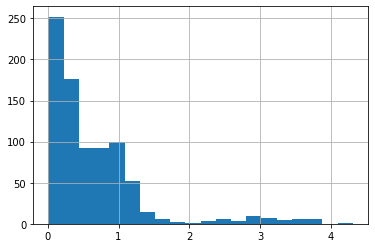

In [45]:
measures[measures.is_go_decision & (measures.RT>0)].RT.hist(bins=20)

<AxesSubplot: >

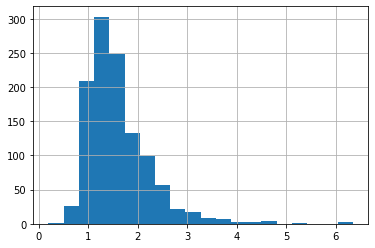

In [46]:
measures[~measures.is_go_decision & (measures.RT>0)].RT.hist(bins=20)

# Measure plots

In [12]:
measures = measures.reset_index()

C:\Users\azgonnikov\AppData\Local\Temp\ipykernel_27136\1904958061.py:12: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "bbox_to_inches" which is no longer supported as of 3.3 and will become an error in 3.6
  plt.savefig("../figures/p_go.png", bbox_to_inches="tight")


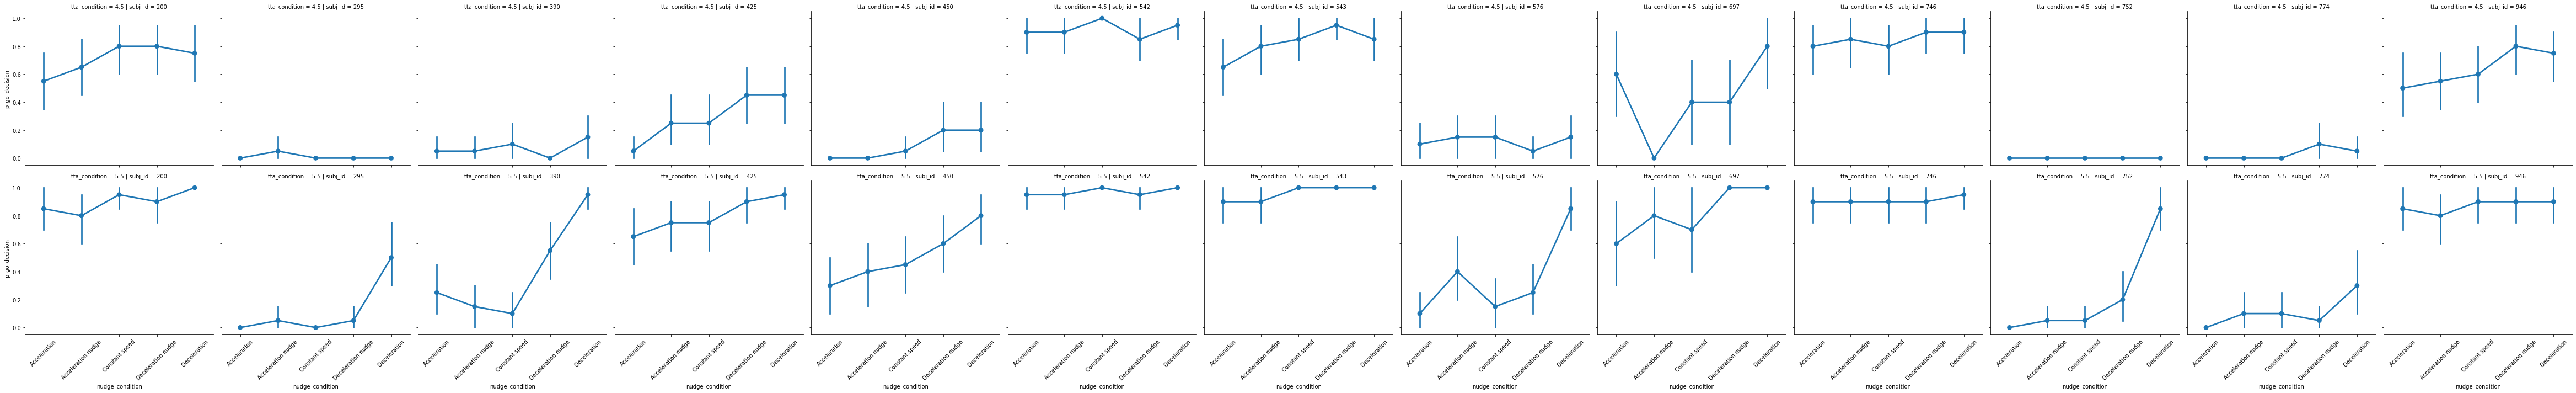

In [13]:
g = sns.catplot(data=measures, x="nudge_condition", y="p_go_decision", row="tta_condition", col="subj_id", kind="point",
            order=["Acceleration",
                   "Acceleration nudge",
                   "Constant speed",
                   "Deceleration nudge",
                   "Deceleration"])
for axes in g.axes:
    for ax in axes:
        ax.set_ylim((-0.05, 1.05))
        ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
plt.tight_layout()
plt.savefig("../figures/p_go.png", bbox_to_inches="tight")

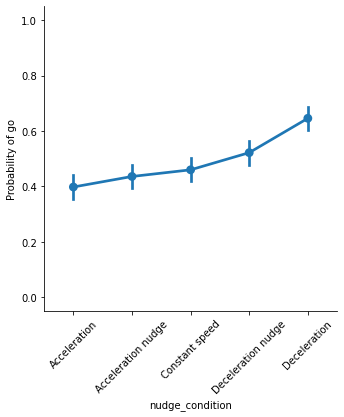

In [15]:
g = sns.catplot(data=measures, x="nudge_condition", y="p_go_decision", # col="tta_condition",
                kind="point",
            order=["Acceleration",
                   "Acceleration nudge",
                   "Constant speed",
                   "Deceleration nudge",
                   "Deceleration"])
for axes in g.axes:
    for ax in axes:
        ax.set_ylim((-0.05, 1.05))
        ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
        ax.set_ylabel("Probability of go")

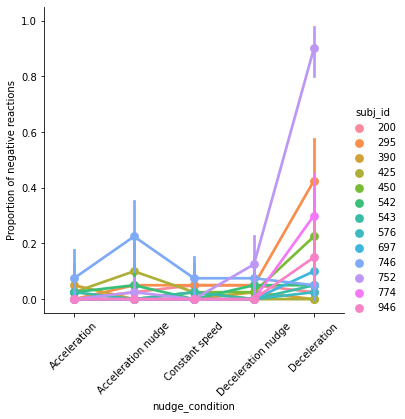

In [16]:
g = sns.catplot(data=measures, x="nudge_condition", y="is_negative_rating", kind="point", hue="subj_id",
               order=["Acceleration",
                   "Acceleration nudge",
                   "Constant speed",
                   "Deceleration nudge",
                   "Deceleration"])

for axes in g.axes:
    for ax in axes:
        ax.set_ylim((-0.05, 1.05))
        ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
        ax.set_ylabel("Proportion of negative reactions")


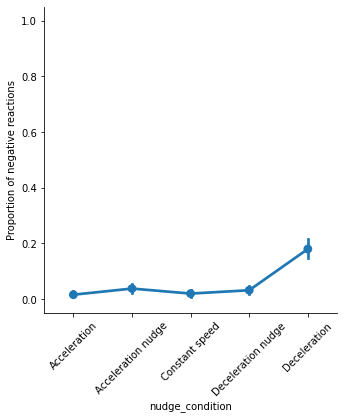

In [17]:
g = sns.catplot(data=measures, x="nudge_condition", y="is_negative_rating", kind="point",
            order=["Acceleration",
                   "Acceleration nudge",
                   "Constant speed",
                   "Deceleration nudge",
                   "Deceleration"])
for axes in g.axes:
    for ax in axes:
        ax.set_ylim((-0.05, 1.05))
        ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
        ax.set_ylabel("Proportion of negative reactions")

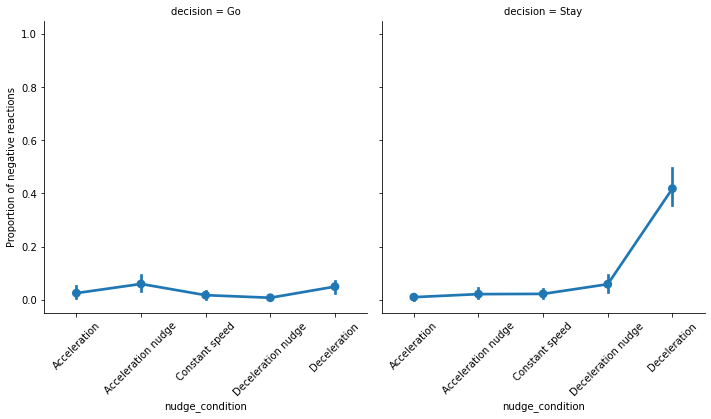

In [18]:
g = sns.catplot(data=measures, x="nudge_condition", y="is_negative_rating", col="decision", kind="point",
            order=["Acceleration",
                   "Acceleration nudge",
                   "Constant speed",
                   "Deceleration nudge",
                   "Deceleration"])
for axes in g.axes:
    for ax in axes:
        ax.set_ylim((-0.05, 1.05))
        ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
        ax.set_ylabel("Proportion of negative reactions")

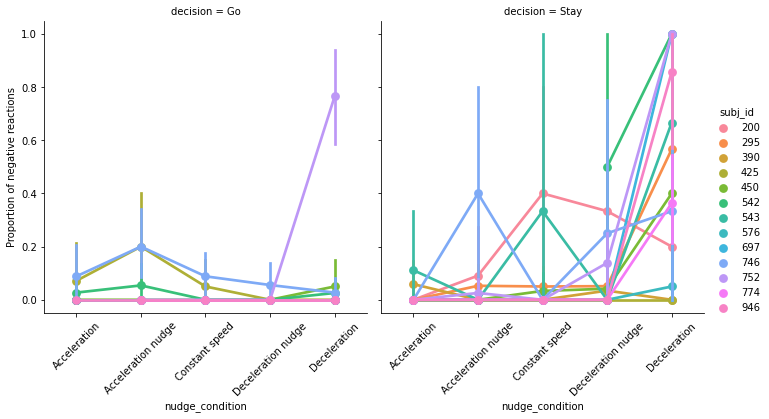

In [19]:
g = sns.catplot(data=measures, x="nudge_condition", y="is_negative_rating", col="decision", kind="point", hue="subj_id",
            order=["Acceleration",
                   "Acceleration nudge",
                   "Constant speed",
                   "Deceleration nudge",
                   "Deceleration"])
for axes in g.axes:
    for ax in axes:
        ax.set_ylim((-0.05, 1.05))
        ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
        ax.set_ylabel("Proportion of negative reactions")